In [49]:
import re
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date

from sklearn import metrics
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot


sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']})

## 读取数据并预处理

In [2]:
balance_sheet = pd.read_excel('农业银行分析指标.xlsx')
income_statement = pd.read_excel('农业银行利润表.xlsx')
lpr = pd.read_excel('macro.xlsx', sheet_name='Sheet1')
gdp = pd.read_excel('macro.xlsx', sheet_name='Sheet2')

In [3]:
def name_2_date(name):
    if re.findall('(一季报|第一季度)', name):
        name = name[:4]+'0331'
    elif re.findall('(中报|第二季度)', name):
        name = name[:4]+'0630'
    elif re.findall('(三季报|第三季度)', name):
        name = name[:4]+'0930'
    elif re.findall('(年报|第四季度)', name):
        name = name[:4]+'1231'
    else:
        raise ValueError('Unsupported name:%s'%name)
    return name

# 处理资产负债表，单位万元
dates = balance_sheet.iloc[1, 1:].map(name_2_date).values
values = balance_sheet.iloc[[10,11,31,66], 1:].values.T
bs_df = pd.DataFrame(values, index=dates, columns=['贷款总额', '存款总额', '不良贷款', '非利息收入']).reindex()

# 处理收入表，单位万元
dates = income_statement.iloc[1, 1:].map(name_2_date).values
values = income_statement.iloc[[29, 6, 20], 1:].values.T
df = pd.DataFrame(values, index=dates, columns=['归母公司利润', '利息净收入', '资产减值损失']).reindex()
df = df.join(bs_df)

# 处理gdp指标，单位万元
gdp['date'] = gdp['date'].map(lambda x: x.strftime('%Y%m%d'))
gdp = gdp.set_index('date')
gdp['GDP'] = gdp['GDP'] * 1e4
df = df.join(gdp)

# 处理lpr指标
def fn(x):
    x = x.strftime('%Y%m%d')
    if x[4:] > '0930':
        return x[:4]+'1231'
    elif x[4:] > '0630':
        return x[:4]+'0930'
    elif x[4:] > '0331':
        return x[:4]+'0630'
    else:
        return x[:4]+'0331'
lpr['date'] = lpr['date'].map(fn)
lpr = lpr.set_index('date')
df = df.join(lpr)

# 转换元素格式
df = df.applymap(lambda x: np.nan if x == '--' else np.float(x))
df = df.sort_index()

# 保存
df.to_csv('ABC_processed.xlsx', index=True)

In [2]:
df_raw = pd.read_csv('ABC_processed.xlsx')
df_raw = df_raw.set_index(df_raw.columns[0])
df_raw.index.name = None

# 获取测试数据和预测值
df_Y = df_raw.iloc[-1, :]
df_raw = df_raw.iloc[:-1, :]
df_raw

,归母公司利润,利息净收入,资产减值损失,贷款总额,存款总额,不良贷款,非利息收入,GDP,LPR
20090930,1876500.0,4398200.0,1405500.0,NaN,NaN,NaN,NaN,8.984690e+08,NaN
20091231,1351300.0,5376100.0,854200.0,4.138187e+08,7.497618e+08,12024100.0,4063500.0,1.008258e+09,NaN
20100331,2497000.0,5354800.0,850000.0,NaN,NaN,NaN,NaN,8.750130e+08,NaN
20100630,2087000.0,5816000.0,1112300.0,4.623983e+08,8.348820e+08,10708600.0,2397200.0,9.934740e+08,NaN
20100930,2430600.0,6231500.0,1292400.0,4.778451e+08,8.664348e+08,9943800.0,3546600.0,1.059637e+09,NaN
20101231,2472700.0,6812900.0,1086500.0,4.956741e+08,8.887905e+08,10040500.0,4826600.0,1.193068e+09,NaN
20110331,3406700.0,7052900.0,1214800.0,5.218154e+08,9.365977e+08,9169800.0,1902700.0,1.044699e+09,NaN
20110630,3260000.0,7420100.0,1554900.0,5.383913e+08,9.706587e+08,9004800.0,3942800.0,1.188959e+09,NaN
20110930,3409000.0,7863400.0,1374200.0,5.487462e+08,9.703827e+08,8795600.0,5581200.0,1.265622e+09,NaN
20111231,2117000.0,8383500.0,2278600.0,5.628705e+08,9.622026e+08,8735800.0,7053200.0,1.380121e+09,NaN


## 可视化

In [6]:
label = '归母公司利润'
def evaluate(y, pred):
    mae = metrics.mean_absolute_error(y, pred)
    mse = metrics.mean_squared_error(y, pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y, pred)
    print("MAE:",mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R-Squared:", r2)
    
def log(y, reverse=False):
    y = np.array(y)
    if reverse:
        #Calculate exp(x) - 1 for all elements in the array.
        return np.expm1(y)
    is_neg = np.where(y<0)
    y[is_neg] = -y[is_neg]
    y = np.log1p(y)
    y[is_neg] = -y[is_neg]
    return y
    
def plot(x, y=None, mode=None, bins=None, title=None, xlabel=None, ylabel=None, image_path=None):
    fig, ax = plt.subplots(figsize=(6,4))
    if mode == 'bar':
        assert y is not None, 'Args `y` must be provided!'
        ax.bar(x, y, width=0.3)
    elif mode == 'hist':
        assert bins is not None, 'Args `bins` must be provided!'
        ax.hist(x, bins=bins)
    else:
        raise ValueError('Unsupported mode!')
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    if image_path:
        plt.savefig(image_path, transparent=False)
    plt.show()

def scatter_plot(col1, col2, df, fn=None, outlier=None, fit_reg=False, image_path=None):
    '''
    col1,col2: two column names
    df: pandas dataframe
    fn: transform function
    outlier: params to show outliers, should be [col_name, threshold]
    fit_reg: whether to show regresstion line
    '''
    df_ = df.copy()
    if fn is not None:
        df_[col1], df_[col2] = fn(df[col1]), fn(df[col2])
    if not fit_reg:
        fig, ax = plt.subplots(figsize=(6,6))
        ax.scatter(df_[col1], df_[col2])
        ax.set(title='Scatter plot', xlabel=col1, ylabel=col2)
    else:
        sns.lmplot(x=col1, y=col2, data=df_, fit_reg=True, height=6, aspect=1.6)
    if outlier and col1 == outlier[0]:
        plt.axvline(outlier[1], color='red')
    elif outlier:
        plt.axhline(outlier[1], color='red')
    if image_path:
        plt.savefig(image_path, transparent=False)
    plt.show()

/home/edili/venv35/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/edili/venv35/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


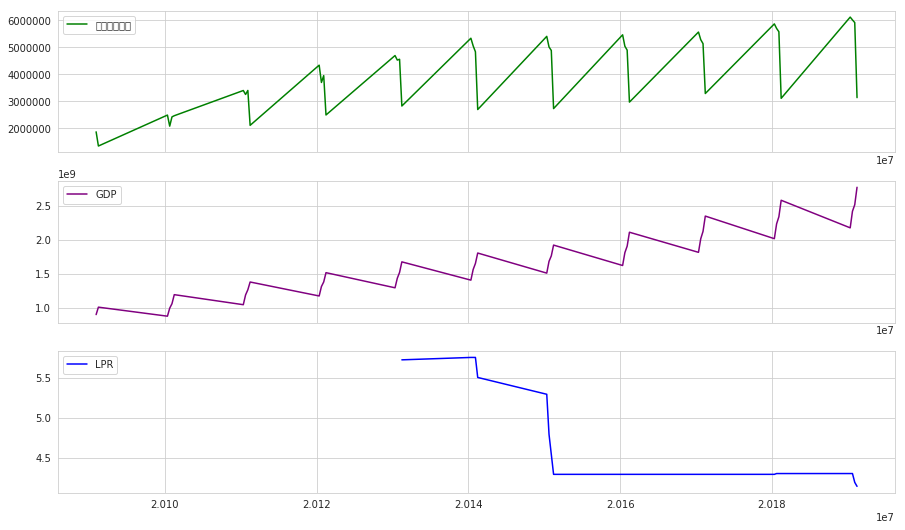

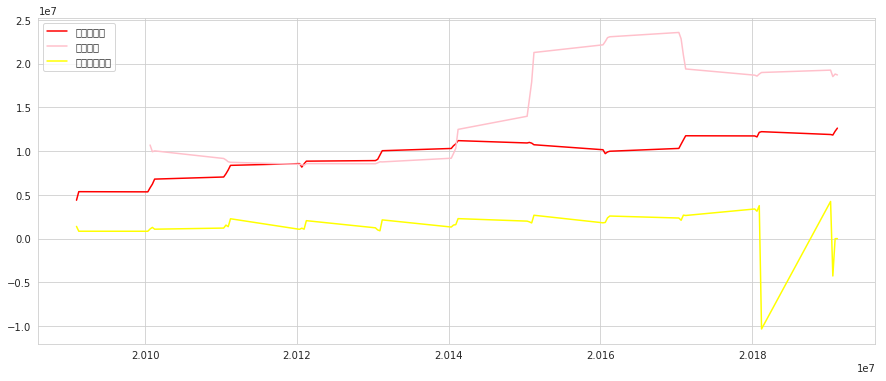

In [4]:
fig, ax = plt.subplots(figsize=(15, 12))
plt.subplot(411)
ax1 = plt.subplot(411)
plt.plot(df_raw['归母公司利润'], color='green')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.legend(loc='upper left')
ax2 = plt.subplot(412, sharex=ax1)
plt.plot(df_raw['GDP'], color='purple')
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.legend(loc='upper left')
ax3 = plt.subplot(413, sharex=ax1)
plt.plot(df_raw['LPR'], color='blue')
plt.setp(ax3.get_xticklabels(), visible=True)
ax3.legend(loc='upper left')
plt.show()

fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(df_raw['利息净收入'], color='red')
plt.plot(df_raw['不良贷款'], color='pink')
plt.plot(df_raw['资产减值损失'], color='yellow')
plt.setp(ax.get_xticklabels(), visible=True)
ax.legend()
plt.show()

## 回归分析

自变量选取为GDP和LPR，原因如下：
1. 行业内一般认为国有银行的净利润受到GDP影响，GDP越大，说明经济越活跃，而银行的主要收入是贷款利息
2. LPR为一年期贷款市场报价利率，即我们说的贷款利息，利率越小，银行利润将会下降
3. 不选用贷款总额、不良贷款、非利息收入等指标来预测的原因主要是这些指标比较难获取；其次这些指标经过一定计算就可以直接得到归母净利润

In [7]:
# 数据平滑
X = df_raw.loc[:, [label, 'GDP', 'LPR']]
X[label] = X[label].rolling(4, min_periods=2).sum()
X['GDP'] = X['GDP'].rolling(4, min_periods=2).sum()

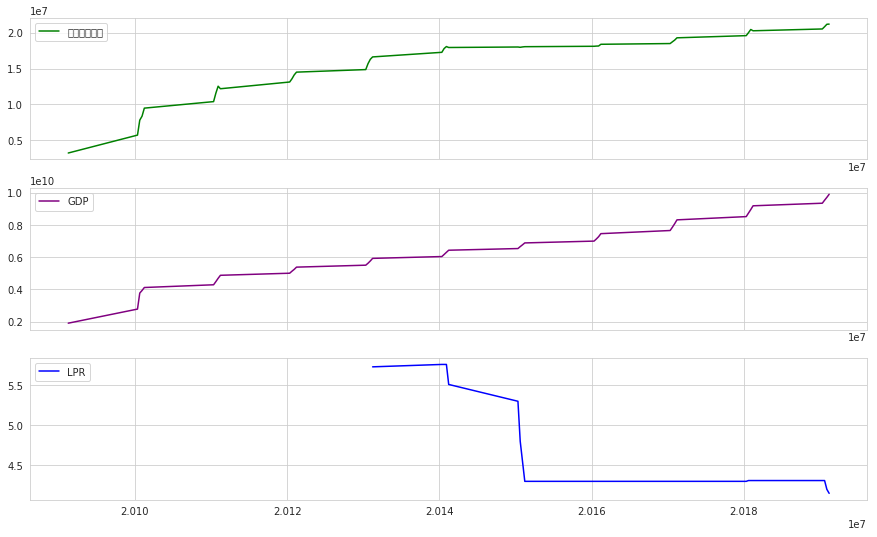

In [8]:
# 绘制平滑曲线
fig, ax = plt.subplots(figsize=(15, 12))
plt.subplot(411)
ax1 = plt.subplot(411)
plt.plot(X[label], color='green')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.legend(loc='upper left')
ax2 = plt.subplot(412, sharex=ax1)
plt.plot(X['GDP'], color='purple')
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.legend(loc='upper left')
ax3 = plt.subplot(413, sharex=ax1)
plt.plot(X['LPR'], color='blue')
plt.setp(ax3.get_xticklabels(), visible=True)
ax3.legend(loc='upper left')
plt.show()

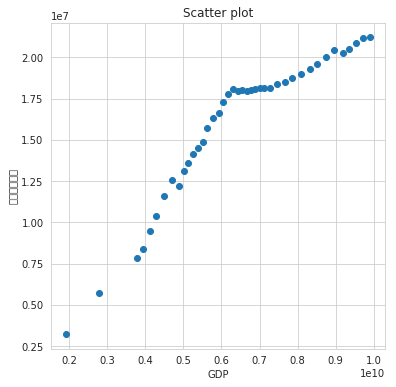

In [9]:
scatter_plot('GDP', label, X)

In [10]:
# 获取因变量和自变量
X['LPR'] = X['LPR'].map(lambda x: 0 if pd.isnull(x) else x)
Y = X[label]
X.drop(label, axis=1, inplace=True)
X = X.dropna()
Y = Y.dropna()

In [11]:
# 自相关性判断, if condition number is too large, it is autocorrelated
# if X.shape[-1] != 1:
#     corr = np.corrcoef(X, rowvar=False)
#     print(np.linalg.det(corr))
#     print(np.linalg.cond(corr))

# 训练
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()

/home/edili/venv35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [13]:
print('评价指标：')
preds = model.fittedvalues
evaluate(Y, preds)
params = model.params
print('多元线性回归公式：\n'
     'Y = {0:.4f}GDP + {1:.3f}LPR + {2:.3f}\n'.format(params[1], params[2], params[0]))
print(model.summary())

评价指标：
MAE: 1053604.1213364622
MSE: 1700368937774.5725
RMSE: 1303981.954543303
R-Squared: 0.9109611787435392
多元线性回归公式：
Y = 0.0018GDP + 436318.475LPR + 3387397.758

                            OLS Regression Results                            
Dep. Variable:                 归母公司利润   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     194.4
Date:                Mon, 18 May 2020   Prob (F-statistic):           1.10e-20
Time:                        03:11:54   Log-Likelihood:                -635.49
No. Observations:                  41   AIC:                             1277.
Df Residuals:                      38   BIC:                             1282.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t    

（1）VIF值：用于检验模型共线性问题。

如果全部小于10（严格是5），则说明模型没有多重共线性问题，模型构建良好；反之若VIF大于10说明模型构建较差。如果出现多重共线性问题，可使用使用逐步回归分析/岭回归分析或者进行相关分析，手工移出相关性非常高的分析项。

（2）D-W值：用于检验变量自相关性。

一般在2附近（1.7~2.3之间），则说明没有自相关性，模型构建良好，反之若D-W值明显偏离2，则说明具有自相关性，模型构建较差。

（3）残差正态性：用于检验模型构建情况。

使用“正态图”检测残差正态性情况，如果残差直观上满足正态性，说明模型构建较好，反之说明模型构建较差。如果残差正态性非常糟糕，建议重新构建模型，比如对Y取对数后再次构建模型等。

（4）异方差性：将保存的残差项，分别与模型的自变量X或者因变量Y，作散点图，查看散点是否有明显的规律性，比如自变量X值越大，残差项越大/越小，这时此说明有规律性，模型具有异方差性，模型构建较差。
https://img-blog.csdn.net/20180812214831924?watermark/2/text/aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3pqbGFtcA==/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70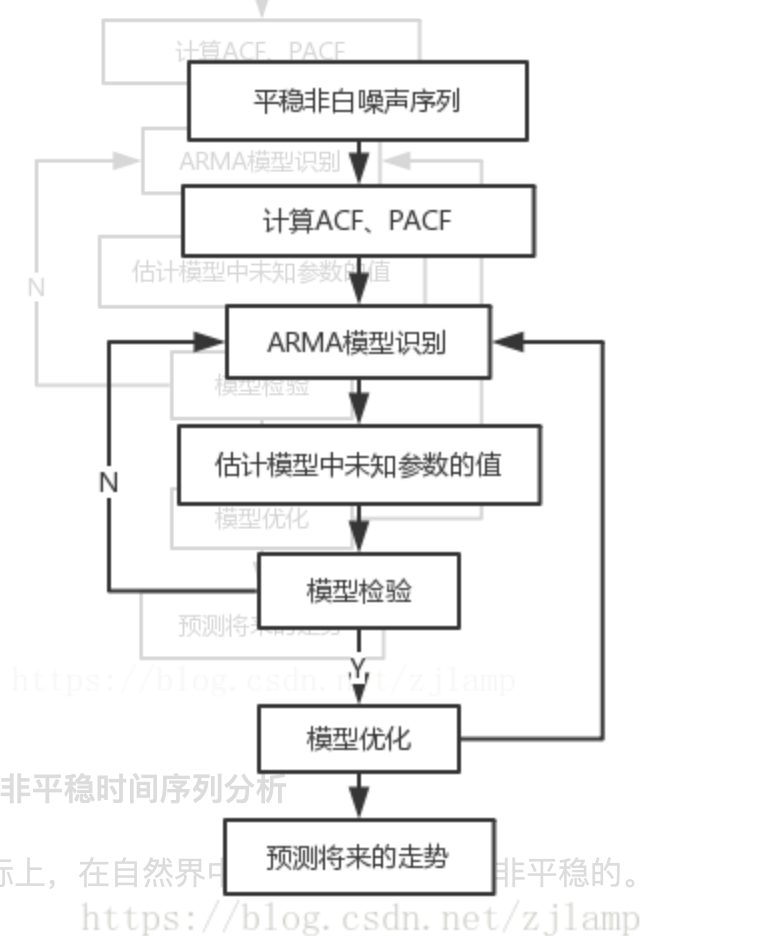
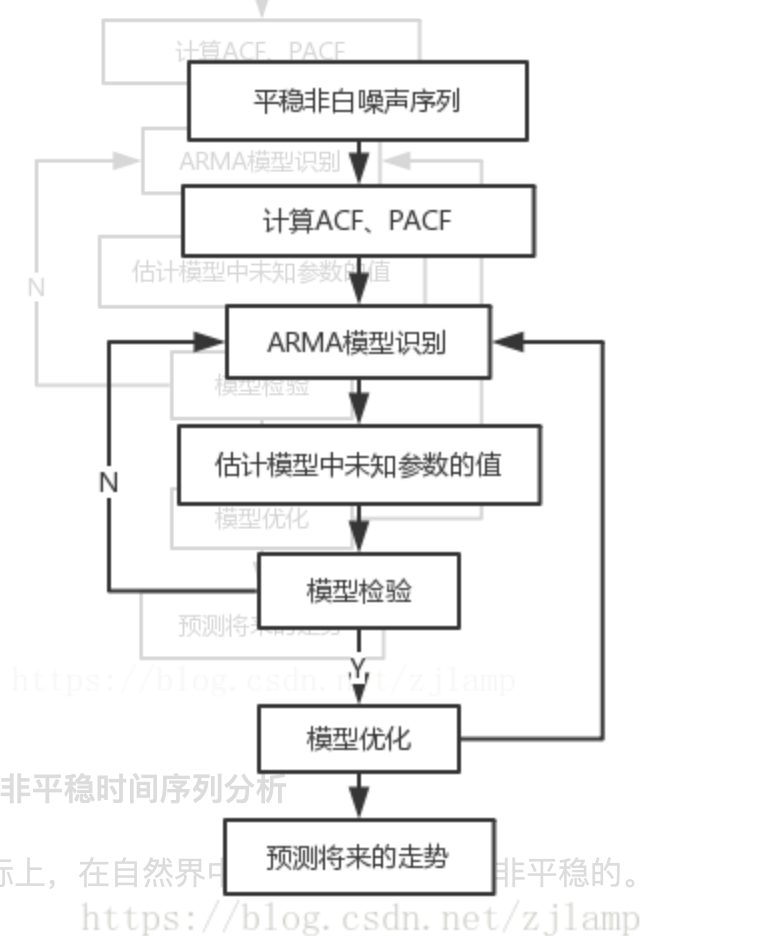

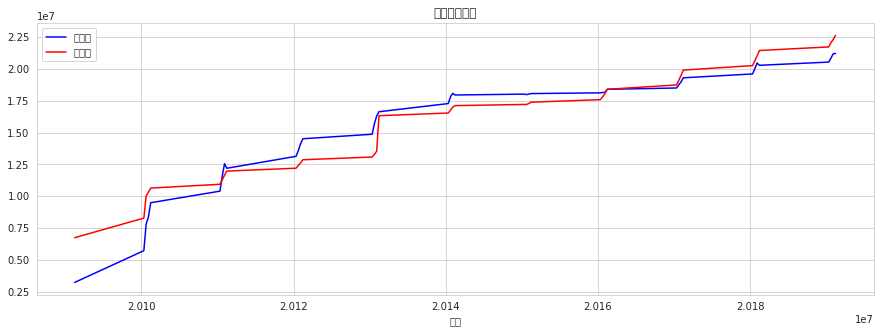

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(Y, color='blue', label='实际值')
plt.plot(preds, color='red', label='预测值')
ax.set(title=label, xlabel='时间')
ax.legend()
plt.show()

基于主流研究机构包括中科院、彭博、第一财经及20余家券商机构的研究报告：
- 2020年GDP增速锁定在[1.4%，5%]之间，即GDP的取值范围在[1004737, 1040407]亿
- LPR锁定在[3.87%, 4.05%]（最低值是假设存在2020全年每季度LPR下调幅度与第一季度相同的极端情况）
- LPR步长设为0.01%, GDP步长设为3567.2亿

结论:
1. 净利润和GDP的趋势大体一致，得到的模型可解释性强
2. 净利润在2013年之后增速变缓，与GDP走势出现偏离，因为2013年7月20日中国人民银行全面放开金融机构贷款利率机制，利率受市场驱动。因而需要加入LPR因子
3. 净利润和GDP周期性明显，需要做平滑处理
4. 最终回归的R方为0.91，说明净利润还受到其他内部或者宏观因素影响
5. 回归模型为`Y = 0.0018GDP + 436318.475LPR + 3387397.758`，预测的2020年归母公司净利润范围为[4684300, 5390340], 单位:万元，然而真实的净利润为6418700万元
6. 局限性:
  - 净利润的周期明显，回归预测周期比较困难
  - 另外从图上可以看到净利润的周期幅度在变大，这个也是回归预测不到的地方

In [15]:
# 预测2020年第一季度净利润
gdp_range = list(range(1004737*10000, 1040408*10000, 3567*10000))
lpr_range = [i/100. for i in range(387, 406, 1)]
res = pd.DataFrame(None, index=lpr_range, columns=gdp_range)
for i in range(len(lpr_range)):
    for j in range(len(gdp_range)):
        res.iloc[i, j] = params[1]*gdp_range[j] + params[2]*lpr_range[i] + params[0] - sum(df_raw.iloc[-4:-1, 0])
res

,10047370000,10083040000,10118710000,10154380000,10190050000,10225720000,10261390000,10297060000,10332730000,10368400000,10404070000
3.87,4.6843e+06,4.74705e+06,4.8098e+06,4.87255e+06,4.9353e+06,4.99805e+06,5.0608e+06,5.12355e+06,5.1863e+06,5.24906e+06,5.31181e+06
3.88,4.68866e+06,4.75141e+06,4.81416e+06,4.87691e+06,4.93966e+06,5.00241e+06,5.06517e+06,5.12792e+06,5.19067e+06,5.25342e+06,5.31617e+06
3.89,4.69302e+06,4.75577e+06,4.81852e+06,4.88128e+06,4.94403e+06,5.00678e+06,5.06953e+06,5.13228e+06,5.19503e+06,5.25778e+06,5.32053e+06
3.90,4.69739e+06,4.76014e+06,4.82289e+06,4.88564e+06,4.94839e+06,5.01114e+06,5.07389e+06,5.13664e+06,5.19939e+06,5.26215e+06,5.3249e+06
3.91,4.70175e+06,4.7645e+06,4.82725e+06,4.89e+06,4.95275e+06,5.0155e+06,5.07826e+06,5.14101e+06,5.20376e+06,5.26651e+06,5.32926e+06
3.92,4.70611e+06,4.76886e+06,4.83161e+06,4.89437e+06,4.95712e+06,5.01987e+06,5.08262e+06,5.14537e+06,5.20812e+06,5.27087e+06,5.33362e+06
3.93,4.71048e+06,4.77323e+06,4.83598e+06,4.89873e+06,4.96148e+06,5.02423e+06,5.08698e+06,5.14973e+06,5.21248e+06,5.27523e+06,5.33799e+06
3.94,4.71484e+06,4.77759e+06,4.84034e+06,4.90309e+06,4.96584e+06,5.02859e+06,5.09134e+06,5.1541e+06,5.21685e+06,5.2796e+06,5.34235e+06
3.95,4.7192e+06,4.78195e+06,4.8447e+06,4.90745e+06,4.97021e+06,5.03296e+06,5.09571e+06,5.15846e+06,5.22121e+06,5.28396e+06,5.34671e+06
3.96,4.72356e+06,4.78632e+06,4.84907e+06,4.91182e+06,4.97457e+06,5.03732e+06,5.10007e+06,5.16282e+06,5.22557e+06,5.28832e+06,5.35108e+06


## 时间序列分析1

时间序列可以分为长期趋势（trend）、季节变动（seasonal）、循环变动（cycling）和随机波动（irregular）四个部分。

长期趋势（ T ）现象在较长时期内受某种根本性因素作用而形成的总的变动趋势
季节变动（ S ）现象在一年内随着季节的变化而发生的有规律的周期性变动
循环变动（ C ）现象以若干年为周期所呈现出的波浪起伏形态的有规律的变动
不规则变动（I ）是一种无规律可循的变动，包括严格的随机变动和不规则的突发性影响很大的变动两种类型


In [171]:
df_raw.head()

,归母公司利润,利息净收入,资产减值损失,贷款总额,存款总额,不良贷款,非利息收入,GDP,LPR
20090930,1876500.0,4398200.0,1405500.0,NaN,NaN,NaN,NaN,8.984690e+08,NaN
20091231,1351300.0,5376100.0,854200.0,413818700.0,749761800.0,12024100.0,4063500.0,1.008258e+09,NaN
20100331,2497000.0,5354800.0,850000.0,NaN,NaN,NaN,NaN,8.750130e+08,NaN
20100630,2087000.0,5816000.0,1112300.0,462398300.0,834882000.0,10708600.0,2397200.0,9.934740e+08,NaN
20100930,2430600.0,6231500.0,1292400.0,477845100.0,866434800.0,9943800.0,3546600.0,1.059637e+09,NaN


In [21]:
label = '归母公司利润'
df = df_raw[[label]]
df['return'] = df[label].diff()
df['log_return_rate'] = np.log(df[label]).diff()
df['rolling_mean'] = df[label].rolling(4, min_periods=2).mean()
df.dropna(inplace=True)
df.head()

/home/edili/venv35/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/edili/venv35/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/edili/venv35/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,归母公司利润,return,log_return_rate,rolling_mean
20091231,1351300.0,-525200.0,-0.328341,1.613900e+06
20100331,2497000.0,1145700.0,0.614023,1.908267e+06
20100630,2087000.0,-410000.0,-0.179362,1.952950e+06
20100930,2430600.0,343600.0,0.152411,2.091475e+06
20101231,2472700.0,42100.0,0.017173,2.371825e+06


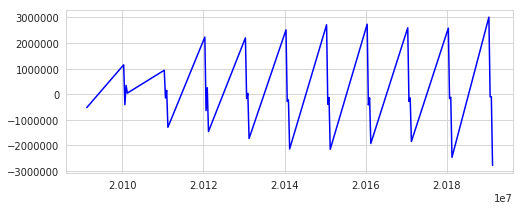

In [22]:
fig, ax = plt.subplots(figsize=(8, 3))
plt.plot(df['return'], color='blue', label='净利润增长')
plt.show()

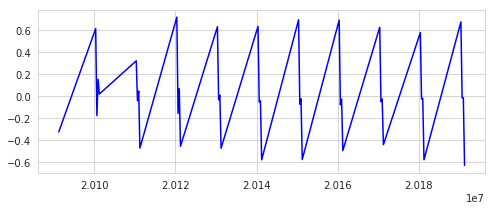

In [23]:
# df = df[df.index > pd.Timestamp('2009-12-01 00:00:00')]
fig, ax = plt.subplots(figsize=(8, 3))
plt.plot(df['log_return_rate'], color='blue', label='净利润增长率')
plt.show()

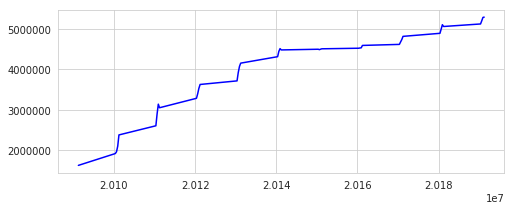

In [24]:
fig, ax = plt.subplots(figsize=(8, 3))
plt.plot(df['rolling_mean'], color='blue', label='净利润移动平均')
plt.show()

在时间序列分析中，为了简化复杂问题，需要做出一些假设，其中最重要的假设就是平稳性。

什么是时间序列的平稳性？

    * 时间序列的统计特征，例如均值、方差、自相关性不随时间而改变    
    * 没有周期
    * 大部分统计模型都依赖这个假设，例如线性回归假设残差服从正态分布，ARIMA模型等等

为什么要假设平稳性？

    - 平稳时间序列易于预测，因为很多描述特征都不随时间改变
    - 这些统计特征只有在平稳的时候才有意义，例如一个时间序列有向上趋势，那么平均值就不准确了
    
时间序列预处理？

    - 差分，difference
    - 对数化
    - deflating
    
如何确定ARIMA的参数？

    - 先预处理使序列平稳化，确定d
    - PACF确定AR项数
    - ACF确定MA项数
    

In [35]:
# Perform Dickey-Fuller test
# 零假设是假设时间序列是非平稳的。当p值小于0.05，拒绝零假设，即时间序列是平稳的
dftest = sm.tsa.adfuller(df[label])
res = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    res['Critical Value ({0})'.format(key)] = value
res

Test Statistic                 -3.204738
p-value                         0.019712
#Lags Used                      4.000000
Number of Observations Used    36.000000
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
Critical Value (1%)            -3.626652
dtype: float64

In [36]:
dftest = sm.tsa.adfuller(df['return'])
res = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    res['Critical Value ({0})'.format(key)] = value
res

Test Statistic                 -2.458317
p-value                         0.125948
#Lags Used                      4.000000
Number of Observations Used    36.000000
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
Critical Value (1%)            -3.626652
dtype: float64

In [37]:
dftest = sm.tsa.adfuller(df['log_return_rate'])
res = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    res['Critical Value ({0})'.format(key)] = value
res

Test Statistic                 -3.353776
p-value                         0.012639
#Lags Used                      4.000000
Number of Observations Used    36.000000
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
Critical Value (1%)            -3.626652
dtype: float64

In [38]:
dftest = sm.tsa.adfuller(df['rolling_mean'])
res = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    res['Critical Value ({0})'.format(key)] = value
res

Test Statistic                 -3.380789
p-value                         0.011631
#Lags Used                      1.000000
Number of Observations Used    39.000000
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
Critical Value (1%)            -3.610400
dtype: float64

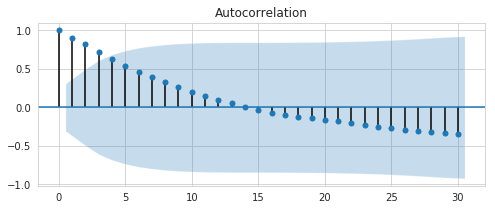

In [60]:
# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(8, 3))
plot_acf(df['rolling_mean'], lags=30, ax=ax)
plt.show()

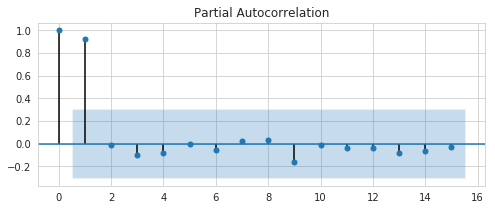

In [71]:
fig, ax = plt.subplots(figsize=(8, 3))
plot_pacf(df['rolling_mean'], lags=15, ax=ax)
plt.show()

ARMA模型的全称是自回归移动平均模型，可以细分为AR模型、MA模型和ARMA模型三类，都可以看做是多元线性回归模型。

In [93]:
ar = ARMA(tuple(df['rolling_mean']), (1, 0)).fit()
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   41
Model:                     ARMA(1, 0)   Log Likelihood                -543.850
Method:                       css-mle   S.D. of innovations         130726.119
Date:                Sat, 30 May 2020   AIC                           1093.700
Time:                        18:45:01   BIC                           1098.841
Sample:                             0   HQIC                          1095.572
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.03e+06      2e+06      2.012      0.044    1.04e+05    7.96e+06
ar.L1.y        0.9975      0.004    261.469      0.000       0.990       1.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0025           +0.0000j            1.0025            0.0000
-----------------------------------------------------------------------------
"""

In [77]:
evaluate(ar.fittedvalues, df['rolling_mean'])

MAE: 157266.5020728389
MSE: 158749474704.33875
RMSE: 398433.77706256125
R-Squared: 0.8385572655254141


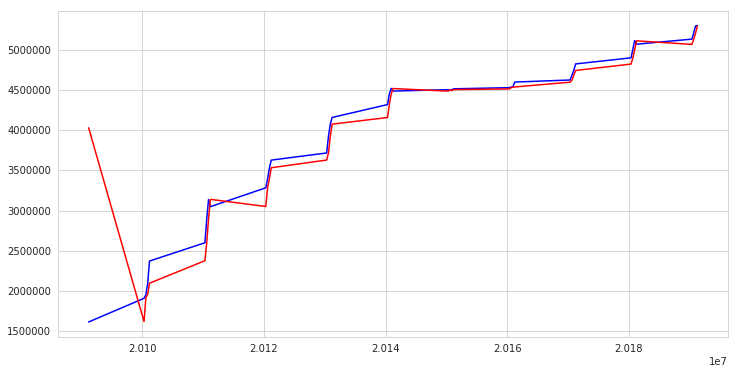

In [85]:
preds = ar.fittedvalues
#阈值0.05，抖动可能是因为时序不平稳，可以i再做一次查分， 用log_return_rate试一下，不行，在做做差分
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(df['rolling_mean'], color='blue')
plt.plot(pd.DataFrame(preds, index=df.index), color='red')
plt.show()

In [180]:
res = ar.forecast(4)
res = pd.DataFrame(res[0], index=['20200331', '20200630', '20200930', '20201231'], columns=['rolling_mean'])
res = pd.concat([df.iloc[-1:, :][['rolling_mean']], res])
pred = res.values[0][0]*4 - sum(df_raw.iloc[-3:, 0])
print('2020年第一季度净利润预测值(万元)：', pred)
res

2020年第一季度净利润预测值(万元)： 6125100.0


,rolling_mean
20191231,5.302450e+06
20200331,5.299322e+06
20200630,5.296201e+06
20200930,5.293088e+06
20201231,5.289982e+06


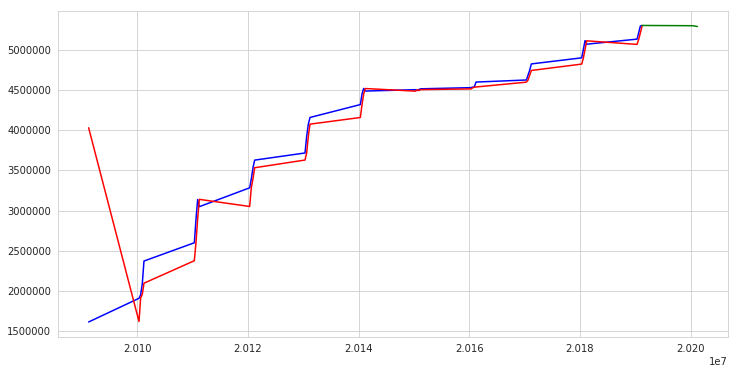

In [181]:
preds = ar.fittedvalues
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(df['rolling_mean'], color='blue')
plt.plot(pd.DataFrame(preds, index=df.index), color='red')
plt.plot(res, color='green')
plt.show()

## 时间序列分析2

In [207]:
label = '归母公司利润'
df = df_raw[[label]]
df['return'] = df[label].diff()
df['log_return_rate'] = np.log(df[label]).diff()
df['rolling_mean'] = df[label].rolling(4, min_periods=2).mean()
df.dropna(inplace=True)
df.head()

cap = 10  #增长函数growth的时候需要设置
df = df[label]
df = df.reset_index()###reset_index?
df.columns = ['ds', 'y']
df['cap'] = cap

/home/edili/venv35/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/edili/venv35/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/edili/venv35/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [208]:
df['ds'] = pd.to_datetime(df['ds'], format='%Y%m%d', errors='ignore')

In [232]:
events = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2013-03-31', '2019-12-31']),
  'lower_window': -8,
  'upper_window': 0,
})

m = Prophet(growth='linear',
            changepoints=['2013-12-31'],
            #holidays=events,
            yearly_seasonality=True, 
            weekly_seasonality=False, 
            daily_seasonality=False)
res = m.fit(df)

In [233]:
future = m.make_future_dataframe(periods=4, freq='Q') #freq为datetime中时间代号
future['cap'] = cap  #增长函数growth的时候需要设置
forecast = m.predict(future)

In [211]:
evaluate(df['y'], forecast['yhat'][:-4])

MAE: 288073.3167069274
MSE: 151828527396.96362
RMSE: 389651.8027636516
R-Squared: 0.9126207278398697


In [216]:
forecast.head()

,ds,trend,cap,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,yhat
0,2009-12-31,-231281.596569,10,-231281.596569,-231281.596569,5.626649e+05,1.625271e+06,1.342806e+06,1.342806e+06,1.342806e+06,0.0,0.0,0.0,1.342806e+06,1.342806e+06,1.342806e+06,1.111524e+06
1,2010-03-31,-138104.542343,10,-138104.542343,-138104.542343,2.867553e+06,3.824088e+06,3.494413e+06,3.494413e+06,3.494413e+06,0.0,0.0,0.0,3.494413e+06,3.494413e+06,3.494413e+06,3.356309e+06
2,2010-06-30,-43892.187703,10,-43892.187703,-43892.187703,2.646730e+06,3.626520e+06,3.167747e+06,3.167747e+06,3.167747e+06,0.0,0.0,0.0,3.167747e+06,3.167747e+06,3.167747e+06,3.123855e+06
3,2010-09-30,51355.467562,10,51355.467562,51355.467562,2.621207e+06,3.610092e+06,3.062090e+06,3.062090e+06,3.062090e+06,0.0,0.0,0.0,3.062090e+06,3.062090e+06,3.062090e+06,3.113446e+06
4,2010-12-31,146603.122827,10,146603.122827,146603.122827,9.101388e+05,1.891580e+06,1.242720e+06,1.242720e+06,1.242720e+06,0.0,0.0,0.0,1.242720e+06,1.242720e+06,1.242720e+06,1.389323e+06


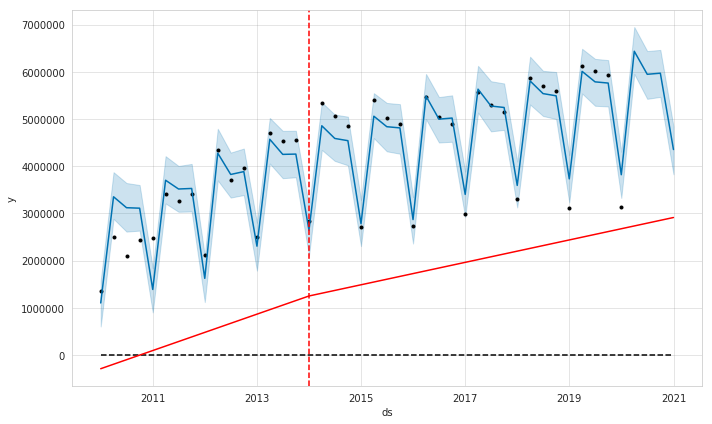

In [235]:
fig = m.plot(forecast)
add_changepoints_to_plot(fig.gca(), m, forecast)
plt.show()

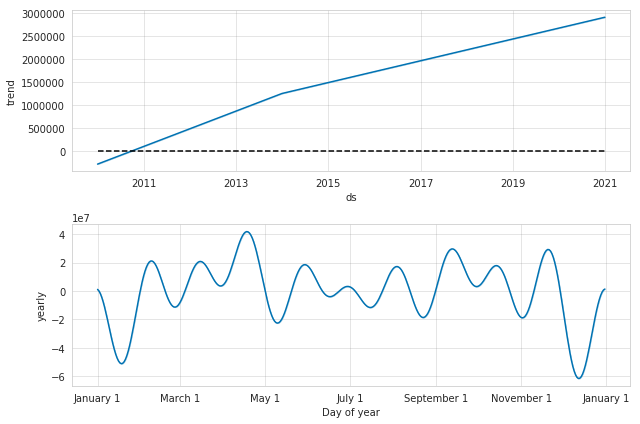

In [236]:
m.plot_components(forecast)
plt.show()

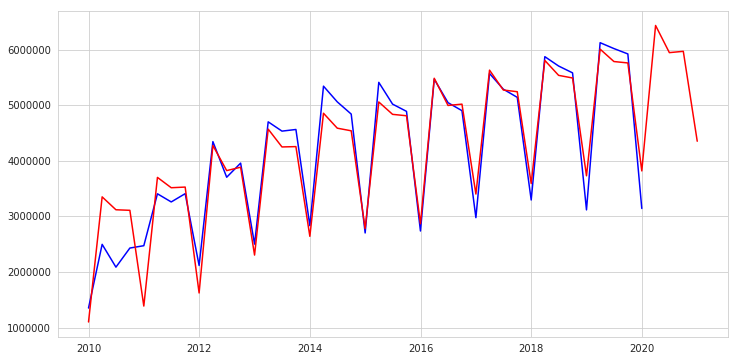

In [237]:
forecast_ = forecast.set_index('ds')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(df['ds'], df['y'], color='blue', label='真实值')
plt.plot(forecast_['yhat'], color='red', label='预测值')
plt.show()

In [243]:
print('2020年第一季度净利润预测值(万元)：', forecast_.loc['2020-03-31', 'yhat'])

2020年第一季度净利润预测值(万元)： 6434971.00768712
